In [12]:
# -*- coding: utf-8 -*-
# Importations
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import psycopg2 as pg
import scipy.special
import pandas_profiling
from pandas.plotting import lag_plot

In [2]:
fct_haemo = pd.read_csv('../data/model/fct_haemodynamic.csv',index_col=0)
fct_haemo['id_patient'] = fct_haemo['id_patient'].astype(int)
fct_haemo['dc'] = fct_haemo['dc'].astype(float)
fct_haemo['fc'] = fct_haemo['fc'].astype(float)
fct_haemo['papdia'] = fct_haemo['papdia'].astype(float)
fct_haemo['papmoy'] = fct_haemo['papmoy'].astype(float)
fct_haemo['papsys'] = fct_haemo['papsys'].astype(float)
fct_haemo['pasd'] = fct_haemo['pasd'].astype(float)
fct_haemo['pasm'] = fct_haemo['pasm'].astype(float)
fct_haemo['pass'] = fct_haemo['pass'].astype(float)
fct_haemo['pnid'] = fct_haemo['pnid'].astype(float)
fct_haemo['pnim'] = fct_haemo['pnim'].astype(float)
fct_haemo['pnis'] = fct_haemo['pnis'].astype(float)

In [3]:
pandas_profiling.ProfileReport(fct_haemo).to_file(outputfile="fct_haemo_profiling.html")

In [4]:
dim_patient = pd.read_csv('../data/dim_patient.csv')

In [5]:
df = pd.merge(fct_haemo, dim_patient[['id_patient','date_transplantation']], on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']
df = df[df['time'] != '0']
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#https://machinelearningmastery.com/time-series-data-visualization-with-python/

# Plotting time series for one patient/one variable

In [7]:
df

,dc,fc,papdia,papmoy,papsys,pasd,pasm,pass,pnid,pnim,pnis,id_patient,time,date_transplantation,timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,110.0,152.0,381,5:11,18/01/2018,2018-01-18 05:11:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:13,18/01/2018,2018-01-18 05:13:00
2,0.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:14,18/01/2018,2018-01-18 05:14:00
3,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,110.0,145.0,381,5:15,18/01/2018,2018-01-18 05:15:00
4,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:16,18/01/2018,2018-01-18 05:16:00
5,0.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:17,18/01/2018,2018-01-18 05:17:00
6,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:18,18/01/2018,2018-01-18 05:18:00
7,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:19,18/01/2018,2018-01-18 05:19:00
8,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,117.0,155.0,381,5:20,18/01/2018,2018-01-18 05:20:00
9,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381,5:21,18/01/2018,2018-01-18 05:21:00


In [8]:
df_melt = pd.melt(df, id_vars=['id_patient','timestamp'], value_vars=['dc','fc','papdip','papmoy','papsys','pasd','pasm','pass','pnid','pnim','pnis'])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [10]:
def plot_haemodynamic(id_patient):
    print('Displaying haemodynamic measures for patient # {}'.format(id_patient))
    g = sns.FacetGrid(df_melt[df_melt['id_patient'] == id_patient], col="variable", col_wrap=4, sharey=False)
    g = g.map(plt.plot, "timestamp", "value")

Displaying haemodynamic measures for patient # 234


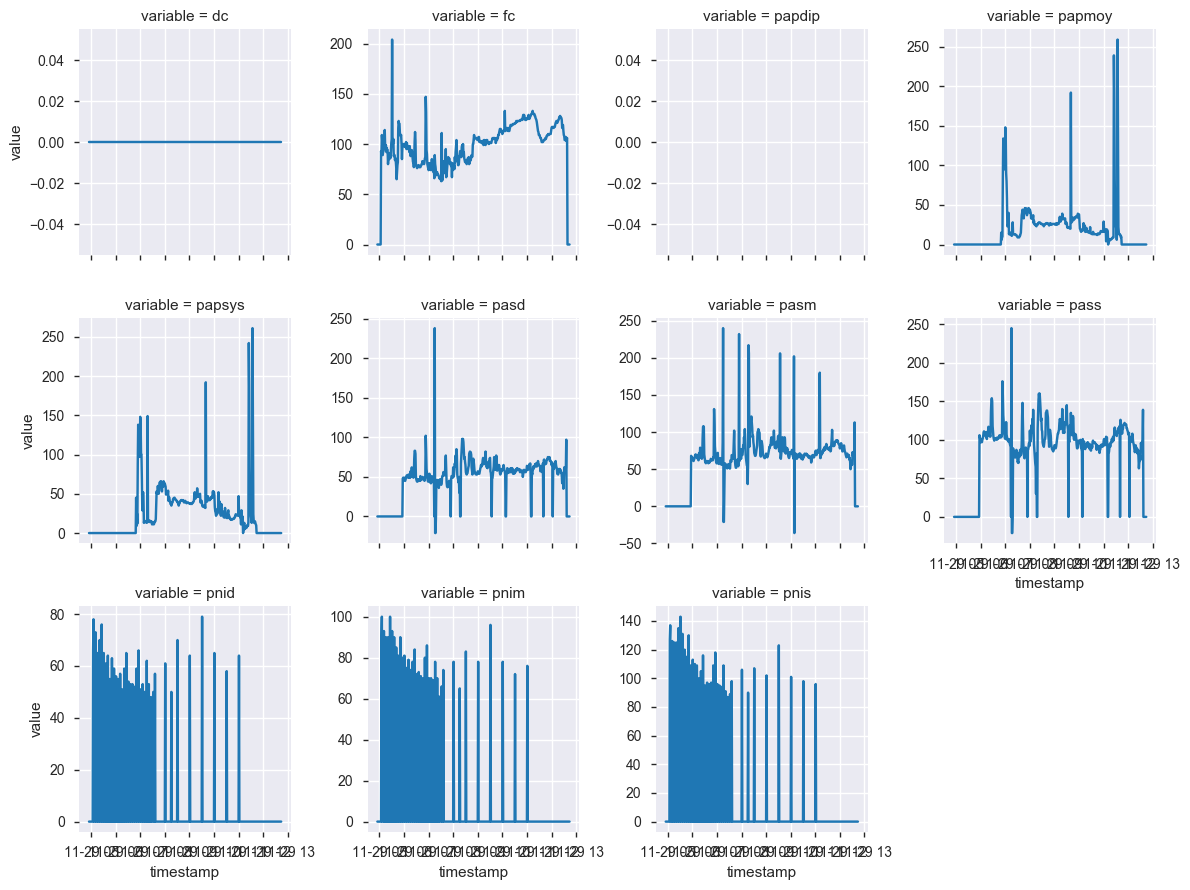

In [15]:
plot_haemodynamic(234)

# Scatter plot of a time serie to investigate its stationarity

In [ ]:
pat = df[df['id_patient'] == 301]
pat = pat.drop(columns=['time','date_transplantation'])
pat['papmoy_shift'] = pat['papmoy'].shift(1)
lag_plot(pat['papmoy'])

# Make a time series stationary with x_t = log(x_t) - log(x_(t-1))

In [ ]:
lag_plot(np.log(pat['papmoy_shift']) - np.log(pat['papmoy']))

In [ ]:
pat['log_papmoy'] = np.log(pat['papmoy_shift']) - np.log(pat['papmoy'])    
pat.plot(y='log_papmoy',x='timestamp')

In [ ]:
pat

In [ ]:
df.id_patient.unique()